# Loading MAST Data Remotely with Intake

This notebooks demonstrates how to remotely load data from the archive using `s3` and [intake](https://intake.readthedocs.io/en/latest/).  

Firstly, let's import the dependancies and load the some configuration. This is just boilerplate for the rest of the notebook.

In [4]:
import intake
import s3fs
import zarr
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import PIL
from IPython.display import Image
from intake.config import conf


with open('config.yml') as file_handle:
    config = yaml.load(file_handle, yaml.FullLoader)


ENDPOINT_URL = config['s3_api']
RESTAPI_ENDPOINT_URL = config['rest_api']

### Zarr & S3
The data in the archive is stored in [Zarr](https://zarr.readthedocs.io/en/stable/getting_started.html) files. Zarr files are very similar to the HDF format. They may store multiple multi-dimensional arrays and similar advanced features such as groups and meta data attributes. The advantages of Zarr over HDF is that the format is optimized for modern cloud storage systems such as `s3`.

[S3](https://aws.amazon.com/pm/serv-s3/?trk=777b3ec4-de01-41fb-aa63-cde3d034a89e&sc_channel=ps&ef_id=Cj0KCQjw06-oBhC6ARIsAGuzdw0F1kYMoyfJjn7PPUEjXp3yCxvohWjtqi1xKyscTg7n9ys01Fi72p8aAnxOEALw_wcB:G:s&s_kwcid=AL!4422!3!638364429349!e!!g!!aws%20s3%20block%20storage!19096959014!142655567223) is a cloud object storage technology for data which organises data into "buckets". The MAST data is stored in a s3 bucket called "mast" at our self-hosted endpoint:


In [2]:
print("S3 endpoint:", ENDPOINT_URL)

S3 endpoint: https://s3.echo.stfc.ac.uk


We can connect to the remote file system using the `s3fs` library. This provides some basic file system functionality, such as listing the entries.

In [6]:
s3 = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': ENDPOINT_URL})

All of the signals are stored in the zarr format under their name at this endpoint. For example, the we can access the plasma current data for shot `30420` at `s3://mast/shots/M9/30420.zarr`. Each zarr file contains all the sources for each shot within the dataset. We can open the contents of the file remotely over s3 without download all the data locally. Here we're going to open the file and list the number of shots (groups) exist within the file.

In [7]:
store = zarr.storage.FSStore('s3://mast/shots/M9/30420.zarr', fs=s3)
store = zarr.LRUStoreCache(store, max_size=2**28)
handle = zarr.open_consolidated(store)
groups = list(handle.groups())

print(f"There are {len(groups)} sources within this shot.")
print('Souces in this shot:', list(handle.keys()))

There are 37 sources within this shot.
Souces in this shot: ['abm', 'ada', 'adg', 'aga', 'ahx', 'aim', 'air', 'ait', 'alp', 'ama', 'amb', 'amc', 'amh', 'amm', 'ane', 'anu', 'aoe', 'arp', 'asb', 'asm', 'asx', 'ayc', 'aye', 'efm', 'esm', 'esx', 'rba', 'rbb', 'rbc', 'rca_pixel1', 'rca_sample1', 'rca_time1', 'rco', 'rgb', 'rgc', 'rir', 'rit']


In [24]:
import xarray as xr
endpoint_url = f"https://s3.echo.stfc.ac.uk"
fs = s3fs.S3FileSystem(anon=True, endpoint_url=endpoint_url)
url = 's3://mast/shots/M9/30420.zarr'
ds = xr.open_dataset(fs.get_mapper(url), engine='zarr', group=f'amc/plasma_current')
ds = ds.compute()
ds

<xarray.Dataset> Size: 360kB
Dimensions:  (time: 30000)
Coordinates:
  * time     (time) float32 120kB -2.0 -2.0 -2.0 -1.999 ... 3.999 3.999 4.0 4.0
Data variables:
    data     (time) float32 120kB 0.4925 -0.03406 0.009959 ... 0.115 0.08558
    error    (time) float32 120kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/17)
    dataset_item_uuid:  6327e756-e587-5c74-8aed-4e595d3546cf
    description:        Plasma Current
    file_name:          None
    format:             None
    label:              Plasma Current
    mds_name:           \TOP.ANALYSED.AMC.PLASMA:CURRENT
    ...                 ...
    shot_id:            30420
    source:             AMC
    status:             1
    time_index:         0
    type:               Analysed
    units:              kA

In [6]:
name = 'amc/plasma_current'

endpoint_url = f"https://s3.echo.stfc.ac.uk"
url = 's3://mast/shots/M9/30420.zarr'
storage_options = {'s3': {'anon': True, 'endpoint_url': endpoint_url}, 'simplecache': {'cache_storage':'/tmp/files'}}
ds = xr.open_dataset("simplecache::" + url, engine='zarr', group=name, storage_options=storage_options)
ds

<xarray.Dataset> Size: 360kB
Dimensions:  (time: 30000)
Coordinates:
  * time     (time) float32 120kB -2.0 -2.0 -2.0 -1.999 ... 3.999 3.999 4.0 4.0
Data variables:
    data     (time) float32 120kB ...
    error    (time) float32 120kB ...
Attributes: (12/17)
    dataset_item_uuid:  6327e756-e587-5c74-8aed-4e595d3546cf
    description:        Plasma Current
    file_name:          None
    format:             None
    label:              Plasma Current
    mds_name:           \TOP.ANALYSED.AMC.PLASMA:CURRENT
    ...                 ...
    shot_id:            30420
    source:             AMC
    status:             1
    time_index:         0
    type:               Analysed
    units:              kA

In [69]:
%%time
name = 'amc/plasma_current'

endpoint_url = f"https://s3.echo.stfc.ac.uk"
url = 'mast/shots/M9/30420.zarr/{name}'
storage_options = {'target_protocol': 's3', 'target_options': {'anon': True, 'endpoint_url': endpoint_url}, 'cache_storage':'/tmp/files'}
ds = xr.open_dataset("simplecache://" + url, engine='zarr', consolidated=True, group=name, storage_options=storage_options)
ds.compute()

CPU times: user 149 ms, sys: 15.8 ms, total: 165 ms
Wall time: 1.79 s


<xarray.Dataset> Size: 360kB
Dimensions:  (time: 30000)
Coordinates:
  * time     (time) float32 120kB -2.0 -2.0 -2.0 -1.999 ... 3.999 3.999 4.0 4.0
Data variables:
    data     (time) float32 120kB 0.4925 -0.03406 0.009959 ... 0.115 0.08558
    error    (time) float32 120kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/17)
    dataset_item_uuid:  6327e756-e587-5c74-8aed-4e595d3546cf
    description:        Plasma Current
    file_name:          None
    format:             None
    label:              Plasma Current
    mds_name:           \TOP.ANALYSED.AMC.PLASMA:CURRENT
    ...                 ...
    shot_id:            30420
    source:             AMC
    status:             1
    time_index:         0
    type:               Analysed
    units:              kA

In [67]:
catalog  = intake.open_catalog('http://localhost:8081/intake/catalog.yml')
dataset = catalog.M9(shot=30420, group='amc/plasma_current').to_dask()
dataset.compute()

CPU times: user 46.6 ms, sys: 6.59 ms, total: 53.2 ms
Wall time: 51.5 ms


/opt/homebrew/anaconda3/envs/mast-book/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 360kB
Dimensions:  (time: 30000)
Coordinates:
  * time     (time) float32 120kB -2.0 -2.0 -2.0 -1.999 ... 3.999 3.999 4.0 4.0
Data variables:
    data     (time) float32 120kB 0.4925 -0.03406 0.009959 ... 0.115 0.08558
    error    (time) float32 120kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/17)
    dataset_item_uuid:  6327e756-e587-5c74-8aed-4e595d3546cf
    description:        Plasma Current
    file_name:          None
    format:             None
    label:              Plasma Current
    mds_name:           \TOP.ANALYSED.AMC.PLASMA:CURRENT
    ...                 ...
    shot_id:            30420
    source:             AMC
    status:             1
    time_index:         0
    type:               Analysed
    units:              kA

### Data Analysis with Remote Data

We're going to perform a simple plotting task. We will:

 - Query the meta database for 10 shots
 - Load the plasma current data as a `xarray.Dataset`
 - Slice every shot between 0 seconds and .3 seconds.
 

In [6]:
from intake.source import registry
list(registry)

['netcdf',
 'opendap',
 'rasterio',
 'remote-xarray',
 'xarray_image',
 'zarr',
 'csv',
 'jsonfiles',
 'numpy',
 'textfiles',
 'tiled_cat',
 'yaml_file_cat',
 'yaml_files_cat',
 'remote_xarray']

In [7]:
df = pd.read_json(RESTAPI_ENDPOINT_URL + '/shots?filters=shot_id$leq:30420,shot_id$geq:30410')

plasma_shots = []
for index, row in df.iterrows():
    dataset = catalog[row['campaign']](shot=row['shot_id'], group='amc/plasma_current')
    dataset = dataset.to_dask()
    dataset = dataset.sel(time=slice(0, .3))
    plasma_shots.append(dataset)

/opt/homebrew/anaconda3/envs/mast-book/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In the code above, we load each item as an `xarray` dataset, with the data, time, and error data all together.

In [8]:
plasma_shots[0]

<xarray.Dataset> Size: 18kB
Dimensions:  (time: 1500)
Coordinates:
  * time     (time) float32 6kB 0.0001998 0.0003998 0.0005996 ... 0.2998 0.3
Data variables:
    data     (time) float32 6kB dask.array<chunksize=(1500,), meta=np.ndarray>
    error    (time) float32 6kB dask.array<chunksize=(1500,), meta=np.ndarray>
Attributes: (12/17)
    dataset_item_uuid:  6327e756-e587-5c74-8aed-4e595d3546cf
    description:        Plasma Current
    file_name:          None
    format:             None
    label:              Plasma Current
    mds_name:           \TOP.ANALYSED.AMC.PLASMA:CURRENT
    ...                 ...
    shot_id:            30420
    source:             AMC
    status:             1
    time_index:         0
    type:               Analysed
    units:              kA

Finally, we can plot the 10 shots we loaded and cropped. 

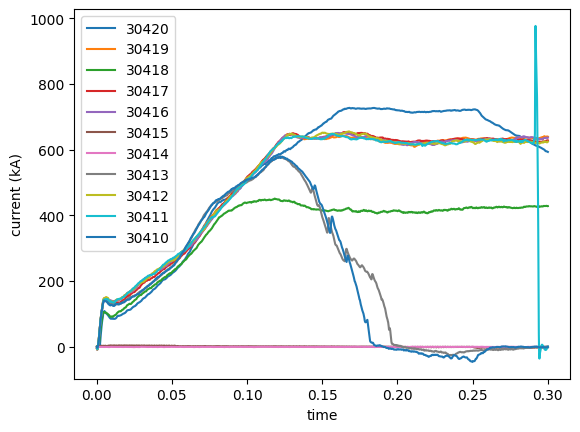

In [9]:
for current in plasma_shots:
    plt.plot(current.time, current.data, label=current.attrs['shot_id'])
    plt.xlabel('time')
    plt.ylabel(f"current ({current.attrs['units']})")

plt.legend()

## Larger Data - Loading RBA Image Data

In this example we show how to load Image data remotely. Image data are just grouped by source, such as the `rba` data. In this example we load all the image data from an `rba` group and create a GIF of the contents.

In [10]:
dataset = catalog['M9'](shot=30390, group='rba')
dataset = dataset.read()
dataset

<xarray.Dataset> Size: 104MB
Dimensions:  (time: 8440, height: 96, width: 128)
Coordinates:
  * time     (time) float64 68kB 1e-05 0.001343 0.002677 ... 0.36 0.36 0.36
Dimensions without coordinates: height, width
Data variables:
    data     (time, height, width) uint8 104MB 0 3 1 1 2 1 ... 32 33 27 26 31 28
Attributes: (12/43)
    CLASS:              IMAGE
    IMAGE_SUBCLASS:     IMAGE_INDEXED
    IMAGE_VERSION:      1.2
    board_temp:         0.0
    bottom:             616
    camera:             
    ...                 ...
    top:                521
    trigger:            -0.10000000149011612
    type:               Image
    vbin:               0
    view:               Hl07 floor mount + FFC2 + 25mm lens + CII filter
    width:              128

In [11]:
imgs = [PIL.Image.fromarray(img) for img in dataset.data.values]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("array.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)
Image(url='array.gif') 